In [67]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [68]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)/x

In [69]:
def potential(x,k,l,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    poten=-10/x-10*torch.sin(torch.pi*x/24)/x
    return poten

In [70]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# 角量子数
l=0
# 控制势函数的大小
scale=10

en_num=70
extend_num=10
epoch=200000
lr=0.01


In [71]:
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)

real_en=eigenvalues[:en_num].detach()
print('initial eigenvalues check:')
print(eigenvalues[:en_num+extend_num])

initial eigenvalues check:
tensor([-5.0551e+01, -1.3759e+01, -6.8472e+00, -4.4070e+00, -3.2510e+00,
        -2.5857e+00, -2.1391e+00, -1.8014e+00, -1.5234e+00, -1.2848e+00,
        -1.0722e+00, -8.7943e-01, -7.0419e-01, -5.4242e-01, -3.9783e-01,
        -3.1259e-01, -2.6561e-01, -2.6173e-01, -2.1234e-01, -1.6620e-01,
        -1.4930e-01, -1.2218e-01, -8.1936e-02, -5.4660e-02, -5.2069e-02,
        -4.5128e-02, -1.4405e-02,  4.0138e-03,  1.3537e-02,  2.6757e-02,
         4.6240e-02,  6.7044e-02,  8.8982e-02,  1.1245e-01,  1.3746e-01,
         1.6365e-01,  1.9150e-01,  2.2076e-01,  2.5125e-01,  2.8285e-01,
         3.1580e-01,  3.5003e-01,  3.8524e-01,  4.2180e-01,  4.5972e-01,
         4.9867e-01,  5.3853e-01,  5.7990e-01,  6.2254e-01,  6.6604e-01,
         7.1057e-01,  7.5635e-01,  8.0323e-01,  8.5115e-01,  9.0040e-01,
         9.5049e-01,  1.0017e+00,  1.0541e+00,  1.1076e+00,  1.1621e+00,
         1.2177e+00,  1.2744e+00,  1.3322e+00,  1.3910e+00,  1.4508e+00,
         1.5116e+00,  1.

In [72]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    V_diag=model(grid)
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    
    output=eigenvalues[:en_num]
    loss=loss_fn(output,real_en)
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
        print('\nepoch:',i)
        print(eigenvalues[:en_num])
        print(real_en)
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:1.724315881729126,time:0.11471199989318848,lr:0.01

epoch: 0
tensor([2.1439e-03, 3.8736e-03, 5.9879e-03, 1.2563e-02, 1.3016e-02, 1.7909e-02,
        2.5796e-02, 3.2324e-02, 4.1672e-02, 5.1193e-02, 6.1537e-02, 7.2883e-02,
        8.5294e-02, 9.8533e-02, 1.1295e-01, 1.2811e-01, 1.4449e-01, 1.6228e-01,
        1.8041e-01, 1.9983e-01, 2.2038e-01, 2.4050e-01, 2.6309e-01, 2.8636e-01,
        3.1028e-01, 3.3633e-01, 3.6242e-01, 3.8942e-01, 4.1765e-01, 4.4666e-01,
        4.7677e-01, 5.0795e-01, 5.4004e-01, 5.7316e-01, 6.0729e-01, 6.4230e-01,
        6.7836e-01, 7.1538e-01, 7.5337e-01, 7.9242e-01, 8.3244e-01, 8.7340e-01,
        9.1539e-01, 9.5833e-01, 1.0023e+00, 1.0472e+00, 1.0930e+00, 1.1400e+00,
        1.1879e+00, 1.2368e+00, 1.2866e+00, 1.3374e+00, 1.3893e+00, 1.4421e+00,
        1.4958e+00, 1.5506e+00, 1.6063e+00, 1.6632e+00, 1.7210e+00, 1.7798e+00,
        1.8397e+00, 1.9002e+00, 1.9619e+00, 2.0247e+00, 2.0881e+00, 2.1528e+00,
        2.2183e+00, 2.2848e+00, 2.3524e+00, 2.

In [73]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

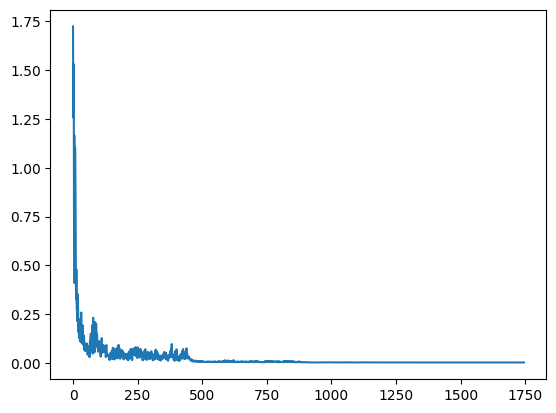

In [74]:
plt.plot(loss_list)
plt.show()

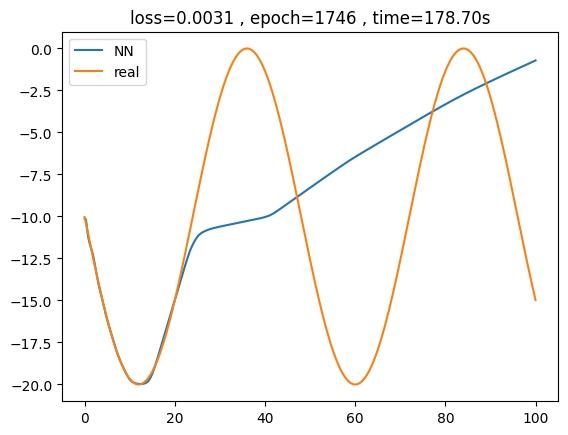

In [75]:
La=0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
# grid=grid[100:]
NN_poten=model(grid)*grid
real_poten=potential(grid,b_lap,l,scale)*grid
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten
         ,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


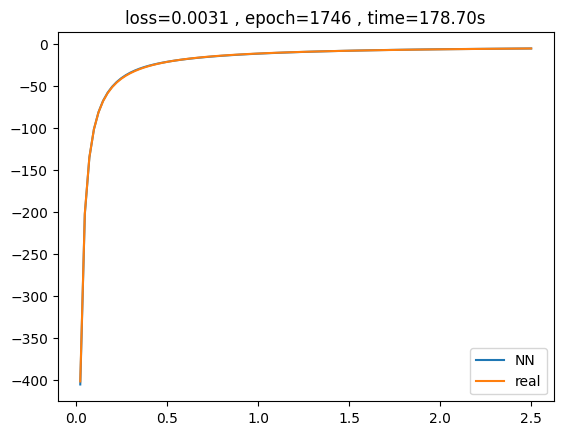

In [76]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:100]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

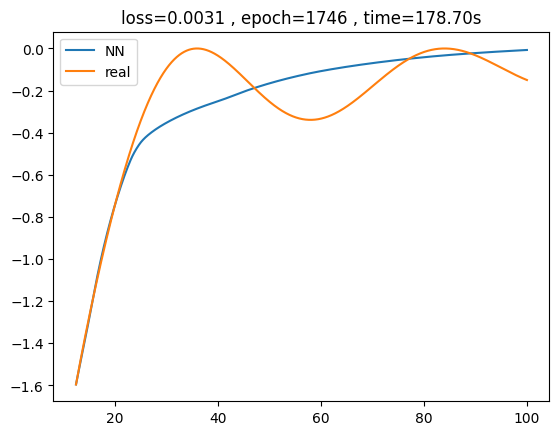

In [77]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[500:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,l,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [78]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num+extend_num]

V_diag=potential(grid,b_lap,l,scale)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
real_en=eigenvalues[:en_num+extend_num]

error=output-real_en
rela_error=error/real_en

print(real_en  )
print(output)
print('final error:',error)
print('relative error:',rela_error)

tensor([-5.0551e+01, -1.3759e+01, -6.8472e+00, -4.4070e+00, -3.2510e+00,
        -2.5857e+00, -2.1391e+00, -1.8014e+00, -1.5234e+00, -1.2848e+00,
        -1.0722e+00, -8.7943e-01, -7.0419e-01, -5.4242e-01, -3.9783e-01,
        -3.1259e-01, -2.6561e-01, -2.6173e-01, -2.1234e-01, -1.6620e-01,
        -1.4930e-01, -1.2218e-01, -8.1936e-02, -5.4660e-02, -5.2069e-02,
        -4.5128e-02, -1.4405e-02,  4.0138e-03,  1.3537e-02,  2.6757e-02,
         4.6240e-02,  6.7044e-02,  8.8982e-02,  1.1245e-01,  1.3746e-01,
         1.6365e-01,  1.9150e-01,  2.2076e-01,  2.5125e-01,  2.8285e-01,
         3.1580e-01,  3.5003e-01,  3.8524e-01,  4.2180e-01,  4.5972e-01,
         4.9867e-01,  5.3853e-01,  5.7990e-01,  6.2254e-01,  6.6604e-01,
         7.1057e-01,  7.5635e-01,  8.0323e-01,  8.5115e-01,  9.0040e-01,
         9.5049e-01,  1.0017e+00,  1.0541e+00,  1.1076e+00,  1.1621e+00,
         1.2177e+00,  1.2744e+00,  1.3322e+00,  1.3910e+00,  1.4508e+00,
         1.5116e+00,  1.5738e+00,  1.6369e+00,  1.7

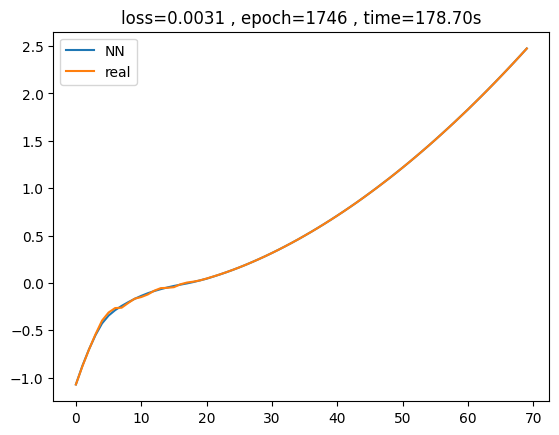

In [79]:
plt.plot(output[10:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[10:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

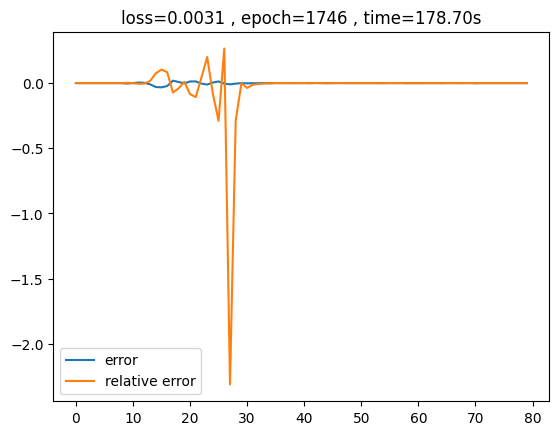

In [80]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()